# Homework 3

#### [문제 1] Fashion MNIST 데이터 정규화를 위한 Mean과 Std. 값 찾기

##### a_fashion_mnist_data.py

In [19]:
import os
from pathlib import Path
import torch
import wandb
from torch import nn

from torch.utils.data import DataLoader, random_split
from torchvision import datasets
from torchvision.transforms import transforms

# BASE_PATH = str(Path(__file__).resolve().parent.parent.parent) 
BASE_PATH = str(Path.cwd().parent.parent.parent)  # 현재 디렉토리 기준으로 부모 디렉토리 이동
print(BASE_PATH)

import sys

sys.path.append(BASE_PATH)

from _01_code._99_common_utils.utils import get_num_cpu_cores, is_linux, is_windows

/data/2_data_server/nlp-05/KOREATECH/2024-2_DL/link_dl


In [20]:
def get_fashion_mnist_data():
    # 데이터 경로 설정 (BASE_PATH 기준으로 _00_data/j_fashion_mnist에 저장)
    data_path = os.path.join(BASE_PATH, "_00_data", "j_fashion_mnist")

    # FashionMNIST 데이터셋 다운로드 및 로드
    # train=True로 학습 데이터셋을 불러오며, transform=transforms.ToTensor()로 이미지를 텐서 형식으로 변환
    f_mnist_train = datasets.FashionMNIST(data_path, train=True, download=True, transform=transforms.ToTensor())
    
    # 학습 데이터셋을 학습용(55,000)과 검증용(5,000)으로 나눔
    f_mnist_train, f_mnist_validation = random_split(f_mnist_train, [55_000, 5_000])

    # 학습 및 검증 데이터셋의 샘플 개수 출력
    print("Num Train Samples: ", len(f_mnist_train))
    print("Num Validation Samples: ", len(f_mnist_validation))
    
    # 데이터셋의 샘플 이미지 크기 출력 (채널 수 1, 높이 28, 너비 28)
    print("Sample Shape: ", f_mnist_train[0][0].shape)  # torch.Size([1, 28, 28])

    # 데이터 로딩에 사용할 CPU 코어 수를 결정 (Linux/Windows는 CPU 코어 수, 그 외는 0으로 설정)
    num_data_loading_workers = get_num_cpu_cores() if is_linux() or is_windows() else 0
    print("Number of Data Loading Workers:", num_data_loading_workers)

    # 학습 데이터 로더 생성
    # 데이터셋: f_mnist_train, 배치 크기: wandb.config.batch_size, 셔플 활성화, pin_memory 활성화, 워커 수: num_data_loading_workers
    train_data_loader = DataLoader(
        dataset=f_mnist_train, batch_size=wandb.config.batch_size, shuffle=True,
        pin_memory=True, num_workers=num_data_loading_workers
    )

    # 검증 데이터 로더 생성
    # 데이터셋: f_mnist_validation, 배치 크기: wandb.config.batch_size, pin_memory 활성화, 워커 수: num_data_loading_workers
    validation_data_loader = DataLoader(
        dataset=f_mnist_validation, batch_size=wandb.config.batch_size,
        pin_memory=True, num_workers=num_data_loading_workers
    )

    # 데이터 정규화를 위한 변환 파이프라인 설정
    # - ConvertImageDtype: 이미지를 torch.float 형식으로 변환
    # - Normalize: 평균(mean=0.0)과 표준편차(std=0.1)로 정규화
    f_mnist_transforms = nn.Sequential(
        transforms.ConvertImageDtype(torch.float),
        transforms.Normalize(mean=0.0, std=0.1),
    )

    # 학습 데이터 로더, 검증 데이터 로더, 변환 파이프라인 반환
    return train_data_loader, validation_data_loader, f_mnist_transforms


In [21]:
def get_fashion_mnist_test_data():
    # 데이터 경로 설정 (BASE_PATH 기준으로 _00_data/j_fashion_mnist에 저장)
    data_path = os.path.join(BASE_PATH, "_00_data", "j_fashion_mnist")

    # 테스트용 FashionMNIST 데이터셋 다운로드 및 로드 (train=False로 테스트 데이터셋 로드)
    # transform 없이 원본 이미지만 로드하는 버전
    f_mnist_test_images = datasets.FashionMNIST(data_path, train=False, download=True)

    # transform=transforms.ToTensor()로 이미지를 텐서 형식으로 변환한 테스트 데이터셋 로드
    f_mnist_test = datasets.FashionMNIST(data_path, train=False, download=True, transform=transforms.ToTensor())

    # 테스트 데이터셋의 샘플 개수 출력
    print("Num Test Samples: ", len(f_mnist_test))
    
    # 데이터셋의 샘플 이미지 크기 출력 (채널 수 1, 높이 28, 너비 28)
    print("Sample Shape: ", f_mnist_test[0][0].shape)  # torch.Size([1, 28, 28])

    # 테스트 데이터 로더 생성
    # - 데이터셋: f_mnist_test
    # - 배치 크기: len(f_mnist_test) (한 번에 전체 데이터 로드)
    test_data_loader = DataLoader(dataset=f_mnist_test, batch_size=len(f_mnist_test))

    # 데이터 정규화를 위한 변환 파이프라인 설정
    # - ConvertImageDtype: 이미지를 torch.float 형식으로 변환
    # - Normalize: 평균(mean=0.0)과 표준편차(std=0.1)로 정규화
    f_mnist_transforms = nn.Sequential(
        transforms.ConvertImageDtype(torch.float),
        # transforms.Normalize(mean=0.0, std=0.1),
        transforms.Normalize(mean=0.2860407531261444, std=0.320453405380249),
    )

    # 원본 테스트 데이터셋, 테스트 데이터 로더, 변환 파이프라인 반환
    return f_mnist_test_images, test_data_loader, f_mnist_transforms


In [6]:
if __name__ == "__main__":
    # 메인 실행 블록 시작
    # wandb 초기 설정 (mode="disabled"로 로깅 비활성화, 설정 값으로 'batch_size' 지정)
    config = {'batch_size': 2048, }  # 배치 크기를 2048로 설정
    wandb.init(mode="disabled", config=config)  # wandb 로깅 비활성화로 초기화

    # FashionMNIST 학습 및 검증 데이터 로더와 변환 파이프라인 로드
    train_data_loader, validation_data_loader, f_mnist_transforms = get_fashion_mnist_data()

    # 빈 줄 출력 (가독성 향상)
    print()

    # FashionMNIST 테스트 데이터셋, 테스트 데이터 로더, 변환 파이프라인 로드
    f_mnist_test_images, test_data_loader, f_mnist_transforms = get_fashion_mnist_test_data()


100.0%


Extracting /data/2_data_server/nlp-05/KOREATECH/2024-2_DL/link_dl/_00_data/j_fashion_mnist/FashionMNIST/raw/train-images-idx3-ubyte.gz to /data/2_data_server/nlp-05/KOREATECH/2024-2_DL/link_dl/_00_data/j_fashion_mnist/FashionMNIST/raw



100.0%


Extracting /data/2_data_server/nlp-05/KOREATECH/2024-2_DL/link_dl/_00_data/j_fashion_mnist/FashionMNIST/raw/train-labels-idx1-ubyte.gz to /data/2_data_server/nlp-05/KOREATECH/2024-2_DL/link_dl/_00_data/j_fashion_mnist/FashionMNIST/raw



100.0%


Extracting /data/2_data_server/nlp-05/KOREATECH/2024-2_DL/link_dl/_00_data/j_fashion_mnist/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to /data/2_data_server/nlp-05/KOREATECH/2024-2_DL/link_dl/_00_data/j_fashion_mnist/FashionMNIST/raw



100.0%

Extracting /data/2_data_server/nlp-05/KOREATECH/2024-2_DL/link_dl/_00_data/j_fashion_mnist/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to /data/2_data_server/nlp-05/KOREATECH/2024-2_DL/link_dl/_00_data/j_fashion_mnist/FashionMNIST/raw

Num Train Samples:  55000
Num Validation Samples:  5000
Sample Shape:  torch.Size([1, 28, 28])
Number of Data Loading Workers: 20

Num Test Samples:  10000
Sample Shape:  torch.Size([1, 28, 28])


##### 정확한 mean 값과 std 값 찾기

In [7]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import torch

def calculate_mean_std(dataset):
    # 모든 이미지의 평균과 표준 편차를 계산
    loader = DataLoader(dataset, batch_size=64, shuffle=False)  # 배치 크기는 성능 최적화를 위해 설정
    mean = 0.0
    std = 0.0
    total_samples = 0

    for images, _ in loader:
        # 배치 단위로 이미지의 픽셀 평균 및 표준 편차 계산
        batch_samples = images.size(0)  # 배치 크기
        images = images.view(batch_samples, -1)  # [N, 1, 28, 28] -> [N, 784]
        mean += images.mean(1).sum()  # 배치 내 평균 계산 후 누적
        std += images.std(1).sum()  # 배치 내 표준 편차 계산 후 누적
        total_samples += batch_samples

    # 전체 데이터셋의 평균 및 표준 편차 계산
    mean /= total_samples
    std /= total_samples

    return mean.item(), std.item()

# Fashion MNIST 데이터셋 불러오기 (텐서 변환만 적용)
dataset = datasets.FashionMNIST(
    root="./data",
    train=True,
    download=True,
    transform=transforms.ToTensor()
)

# 평균(mean)과 표준 편차(std) 계산
mean, std = calculate_mean_std(dataset)

print(f"Mean: {mean}")
print(f"Std: {std}")

100.0%


Extracting ./data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100.0%


Extracting ./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



100.0%


Extracting ./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100.0%


Extracting ./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw

Mean: 0.2860407531261444
Std: 0.320453405380249


#### [문제 2] Fashion MNIST 데이터에 대하여 CNN 학습시키기

##### a_mnist_train_cnn.py

In [42]:
import torch
from torch import nn, optim
from datetime import datetime
import os
import wandb
from pathlib import Path
import argparse

# BASE_PATH = str(Path(__file__).resolve().parent.parent.parent) 
BASE_PATH = str(Path.cwd().parent.parent.parent)  # 현재 디렉토리 기준으로 부모 디렉토리 이동
import sys
sys.path.append(BASE_PATH)

# CURRENT_FILE_PATH = os.path.dirname(os.path.abspath(__file__))
CURRENT_FILE_PATH = os.getcwd()
CHECKPOINT_FILE_PATH = os.path.join(CURRENT_FILE_PATH, "checkpoints")
if not os.path.isdir(CHECKPOINT_FILE_PATH):
  os.makedirs(os.path.join(CURRENT_FILE_PATH, "checkpoints"))

import sys
sys.path.append(BASE_PATH)

from _01_code._08_fcn_best_practice.c_trainer import ClassificationTrainer
# from _01_code._08_fcn_best_practice.f_mnist_train_fcn import get_mnist_data
from _01_code._08_fcn_best_practice.e_arg_parser import get_parser

In [43]:
def get_cnn_model():
    # MyModel이라는 CNN 기반 신경망 정의
    class MyModel(nn.Module):
        def __init__(self, in_channels, n_output):
            super().__init__()

            # CNN 구조 정의
            self.model = nn.Sequential(
                # 첫 번째 Conv2d 레이어
                # 입력 크기: B x 1 x 28 x 28
                # 출력 크기: B x 6 x (28 - 5 + 1) x (28 - 5 + 1) = B x 6 x 24 x 24
                nn.Conv2d(in_channels=in_channels, out_channels=6, kernel_size=(5, 5), stride=(1, 1)),
                
                # 첫 번째 MaxPooling 레이어
                # 입력 크기: B x 6 x 24 x 24
                # 출력 크기: B x 6 x 12 x 12
                nn.MaxPool2d(kernel_size=2, stride=2),
                
                # 활성화 함수 ReLU 적용
                nn.ReLU(),

                # 두 번째 Conv2d 레이어
                # 입력 크기: B x 6 x 12 x 12
                # 출력 크기: B x 16 x (12 - 5 + 1) x (12 - 5 + 1) = B x 16 x 8 x 8
                nn.Conv2d(in_channels=6, out_channels=16, kernel_size=(5, 5), stride=(1, 1)),

                # 두 번째 MaxPooling 레이어
                # 입력 크기: B x 16 x 8 x 8
                # 출력 크기: B x 16 x 4 x 4
                nn.MaxPool2d(kernel_size=2, stride=2),
                
                # 활성화 함수 ReLU 적용
                nn.ReLU(),

                # Flatten 레이어: 다차원 텐서를 1차원 텐서로 변환
                # 입력 크기: B x 16 x 4 x 4
                # 출력 크기: B x (16 * 4 * 4) = B x 256
                nn.Flatten(),

                # 첫 번째 완전연결(Linear) 레이어
                # 입력 크기: B x 256
                # 출력 크기: B x 128
                nn.Linear(256, 128),

                # 활성화 함수 ReLU 적용
                nn.ReLU(),

                # 두 번째 완전연결(Linear) 레이어
                # 입력 크기: B x 128
                # 출력 크기: B x n_output
                nn.Linear(128, n_output),
            )

        # 모델의 순전파(forward) 정의
        def forward(self, x):
            # Sequential로 정의된 레이어를 순차적으로 처리
            x = self.model(x)
            return x

    # MyModel 인스턴스 생성
    # 입력 채널 크기: 1 (Fashion MNIST는 흑백 이미지)
    # 출력 크기: 10 (10개의 클래스 분류)
    my_model = MyModel(in_channels=1, n_output=10)

    # 생성된 모델 반환
    return my_model


In [59]:
def main(args):
    print(f"WandB: {args.wandb}")
    print(f"Batch size: {args.batch_size}")
    print(f"learning rate: {args.learning_rate}")
    print(f"Validation interval: {args.validation_interval}")
    
    run_time_str = datetime.now().astimezone().strftime('%Y-%m-%d_%H-%M-%S')

    config = {'wandb': True,
            'batch_size': 2048,
            'learning_rate': 1e-3,
            'epochs': 1000,                # 에포크 수
            'validation_interval': 10,
            'checkpoint_file_path': CHECKPOINT_FILE_PATH,
            'early_stop_patience': 5,    # 조기 종료를 위한 patience 설정
            'early_stop_delta': 0.001,    # 조기 종료를 위한 최소 변화량
            'validation_intervals': 10   # 검증 간격 추가
    }  
    wandb.init(mode="online", config=config) 

    # FashionMNIST 데이터 로더 및 변환 파이프라인 설정
    # - 학습 데이터 로더: train_data_loader
    # - 검증 데이터 로더: validation_data_loader
    # - 데이터 변환 규칙: f_mnist_transforms
    train_data_loader, validation_data_loader, f_mnist_transforms = get_fashion_mnist_data()

    # CNN 모델 학습 설정
    # 프로젝트 이름 지정 및 wandb 초기화 (활성화 여부는 args.wandb로 결정)
    project_name = "cnn_fashion_mnist"  # 프로젝트 이름 설정
    wandb.init(
        mode="online" if args.wandb else "disabled",  # wandb 활성화 여부
        project=project_name,  # wandb 프로젝트 이름
        notes="FashionMNIST experiment with cnn",  # 프로젝트 설명
        tags=["cnn", "fashion_mnist"],  # 태그 설정
        name=run_time_str,
        config=config  # wandb 설정값 적용
    )

    # 학습에 사용할 디바이스 설정: GPU 사용 가능하면 GPU, 아니면 CPU
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    print(f"Training on device {device}.")  # 학습에 사용될 디바이스 출력

    # CNN 모델 초기화 및 디바이스로 이동
    model = get_cnn_model()  # 사용자 정의 CNN 모델 생성
    model.to(device)  # 모델을 디바이스(GPU/CPU)로 이동
    wandb.watch(model)  # wandb로 모델 로깅 설정

    # SGD 최적화기(Optimizer) 설정: 모델의 파라미터와 학습률 지정
    optimizer = optim.SGD(model.parameters(), lr=wandb.config.learning_rate)

    # ClassificationTrainer 초기화: 학습, 검증 루프 관리
    classification_trainer = ClassificationTrainer(
        project_name, model, optimizer, train_data_loader, validation_data_loader, f_mnist_transforms,
        run_time_str, wandb, device, CHECKPOINT_FILE_PATH
    )
    # 학습 루프 실행
    classification_trainer.train_loop()

    # wandb 세션 종료
    wandb.finish()


In [60]:
if __name__ == "__main__":
    # # Jupyter Notebook 환경에서 추가된 인자를 제거
    # sys.argv = [arg for arg in sys.argv if not arg.startswith("--f=")]

    # # argparse 설정
    # parser = argparse.ArgumentParser()

    # parser.add_argument(
    #     "--wandb", action=argparse.BooleanOptionalAction, default=True, help="True or False"
    # )
    # parser.add_argument(
    #     "-b", "--batch_size", type=int, default=2048, help="Batch size (int, default: 2048)"
    # )
    # parser.add_argument(
    #     "-r", "--learning_rate", type=float, default=1e-3, help="Number of training epochs (float, default:1e-3)"
    # )
    # parser.add_argument(
    #     "-v", "--validation_interval", type=int, default=10, help="Validation interval (int, default: 10)"
    # )

    # # 명령줄 인자를 파싱
    # args = parser.parse_args()

    # # main 함수 실행
    main(args)

wandb: Currently logged in as: chosuyeon (chosuyeon-korea-university-of-technology-and-education). Use `wandb login --relogin` to force relogin


WandB: True
Batch size: 2048
learning rate: 0.001
Validation interval: 10


Num Train Samples:  55000
Num Validation Samples:  5000
Sample Shape:  torch.Size([1, 28, 28])
Number of Data Loading Workers: 20


Training on device cuda:0.
[Epoch   1] T_loss: 2.27307, T_accuracy: 17.0400 | V_loss: 2.24955, V_accuracy: 18.1600 | Early stopping is stated! | T_time: 00:00:02, T_speed: 0.500
[Epoch  10] T_loss: 1.78639, T_accuracy: 50.6327 | V_loss: 1.73340, V_accuracy: 51.8800 | V_loss decreased (2.24955 --> 1.73340). Saving model... | T_time: 00:00:15, T_speed: 0.667
[Epoch  20] T_loss: 1.07043, T_accuracy: 63.5255 | V_loss: 1.04020, V_accuracy: 65.0000 | V_loss decreased (1.73340 --> 1.04020). Saving model... | T_time: 00:00:29, T_speed: 0.690
[Epoch  30] T_loss: 0.89419, T_accuracy: 67.8691 | V_loss: 0.87429, V_accuracy: 68.1800 | V_loss decreased (1.04020 --> 0.87429). Saving model... | T_time: 00:00:44, T_speed: 0.682
[Epoch  40] T_loss: 0.82273, T_accuracy: 70.4927 | V_loss: 0.80785, V_accuracy: 70.6200 | V_loss decreased (0.87429 --> 0.80785). Saving model... | T_time: 00:00:59, T_speed: 0.678
[Epoch  50] T_loss: 0.77712, T_accuracy: 71.8364 | V_loss: 0.76885, V_accuracy: 72.0400 | V_loss d

Epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
Training accuracy (%),▁▆▆▇▇▇▇▇▇▇▇▇▇███████████████████████████
Training loss,█▄▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Training speed (epochs/sec.),▁█▇███▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇
Validation accuracy (%),▁▆▆▆▇▇▇▇▇▇▇█▇███████████████████████████
Validation loss,█▃▂▂▂▂▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Epoch,1000
Training accuracy (%),86.95091
Training loss,0.36487
Training speed (epochs/sec.),0.67385
Validation accuracy (%),86.76


#### [문제 3] 학습 완료된 모델로 테스트 데이터 Accuracy 확인하기

In [61]:
import numpy as np
from matplotlib import pyplot as plt
from _01_code._08_fcn_best_practice.d_tester import ClassificationTester

Num Test Samples:  10000
Sample Shape:  torch.Size([1, 28, 28])
MODEL FILE: /data/2_data_server/nlp-05/KOREATECH/2024-2_DL/link_dl/_03_your_code/CSE533/hw3/checkpoints/mnist_checkpoint_latest.pt
TEST RESULTS: 77.890%

     LABEL: 9


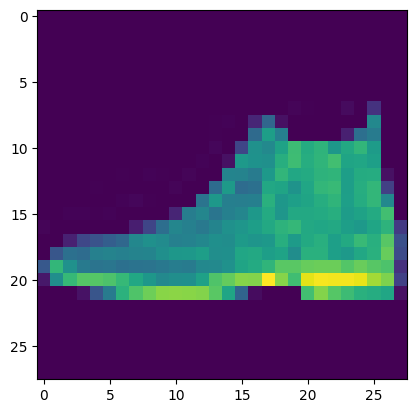

PREDICTION: 5


In [64]:
def main():
    # 테스트 데이터 로더와 변환 파이프라인 로드
    # flatten=False로 CNN에 적합한 2D 이미지 형태 유지
    mnist_test_images, test_data_loader, mnist_transforms = get_fashion_mnist_test_data()

    # CNN 모델 생성
    test_model = get_cnn_model()

    # ClassificationTester 객체 생성
    # - 데이터셋 이름: "mnist"
    # - 모델: test_model
    # - 테스트 데이터 로더: test_data_loader
    # - 데이터 변환: mnist_transforms
    # - 체크포인트 파일 경로: CHECKPOINT_FILE_PATH
    classification_tester = ClassificationTester(
        "mnist", test_model, test_data_loader, mnist_transforms, CHECKPOINT_FILE_PATH
    )

    # 테스트 데이터셋 평가 수행
    classification_tester.test()

    print()  # 빈 줄 출력 (가독성 향상)

    # 첫 번째 테스트 데이터 샘플 가져오기
    img, label = mnist_test_images[0]  # img: 이미지 데이터, label: 실제 라벨 값
    print("     LABEL:", label)  # 실제 라벨 출력

    # 이미지 시각화
    plt.imshow(img)  # 이미지를 플롯에 표시
    plt.show()  # 플롯을 화면에 출력

    # 테스트 데이터셋에서 첫 번째 샘플의 모델 예측 수행
    # 1. img 데이터를 numpy 배열로 변환: np.array(mnist_test_images[0][0])
    # 2. torch 텐서로 변환: torch.tensor(...)
    # 3. CNN 입력 크기에 맞게 차원 추가: unsqueeze(dim=0)를 두 번 호출하여 (1, 1, 28, 28)로 만듦
    #    - 첫 번째 unsqueeze: 배치 차원 추가
    #    - 두 번째 unsqueeze: 채널 차원 추가
    #    결과 크기: torch.Size([1, 1, 28, 28])
    output = classification_tester.test_single(
        torch.tensor(np.array(mnist_test_images[0][0])).unsqueeze(dim=0).unsqueeze(dim=0)
    )

    # 모델의 예측 결과 출력
    print("PREDICTION:", output)


if __name__ == "__main__":
    # 스크립트가 직접 실행될 경우 main 함수 호출
    main()

#### [문제 4] 샘플 테스트 데이터 분류 예측 결과 확인하기

Num Test Samples:  10000
Sample Shape:  torch.Size([1, 28, 28])
MODEL FILE: /data/2_data_server/nlp-05/KOREATECH/2024-2_DL/link_dl/_03_your_code/CSE533/hw3/checkpoints/mnist_checkpoint_latest.pt
TEST RESULTS: 77.890%

Random 10 Sample Predictions



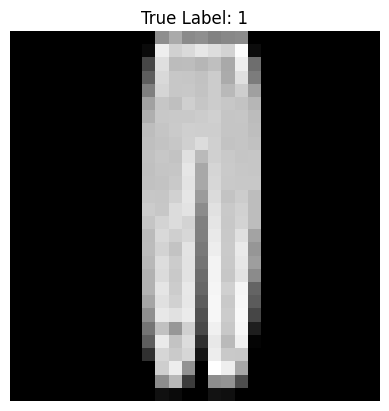

Sample Index: 2115
True Label: 1
Predicted Label: 1
Result: Correct Prediction



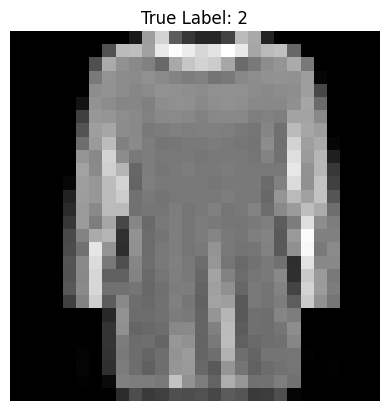

Sample Index: 413
True Label: 2
Predicted Label: 2
Result: Correct Prediction



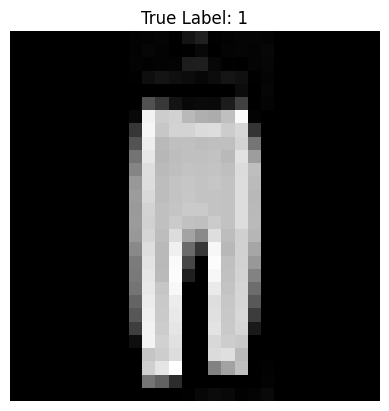

Sample Index: 1697
True Label: 1
Predicted Label: 1
Result: Correct Prediction



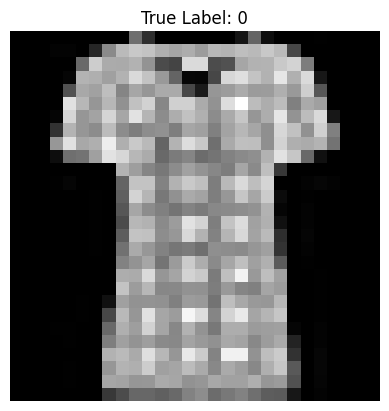

Sample Index: 4958
True Label: 0
Predicted Label: 0
Result: Correct Prediction



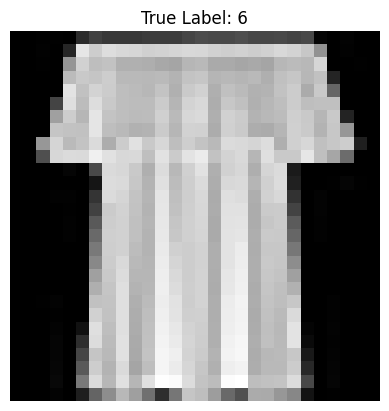

Sample Index: 2006
True Label: 6
Predicted Label: 0
Result: Incorrect Prediction



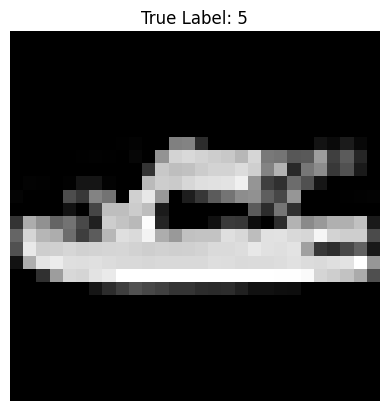

Sample Index: 9285
True Label: 5
Predicted Label: 5
Result: Correct Prediction



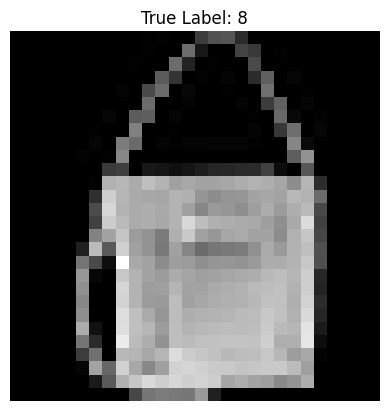

Sample Index: 8970
True Label: 8
Predicted Label: 8
Result: Correct Prediction



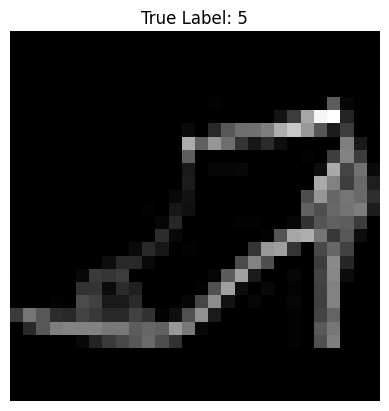

Sample Index: 3391
True Label: 5
Predicted Label: 5
Result: Correct Prediction



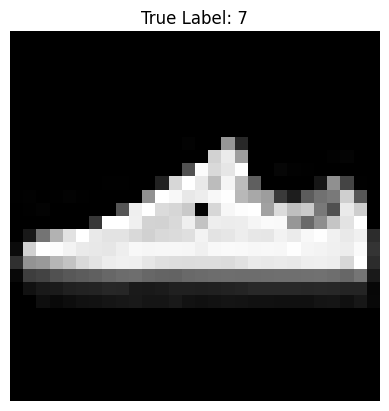

Sample Index: 6193
True Label: 7
Predicted Label: 7
Result: Correct Prediction



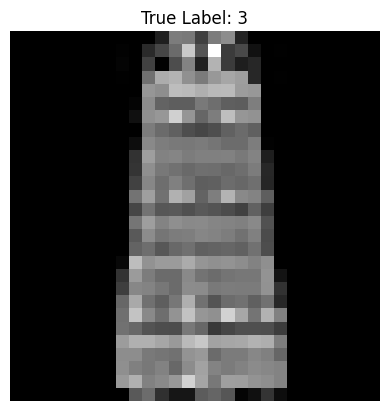

Sample Index: 9101
True Label: 3
Predicted Label: 3
Result: Correct Prediction



In [66]:
import random
import torch
import numpy as np
import matplotlib.pyplot as plt

def main():
    # 테스트 데이터 로더와 변환 파이프라인 로드
    # flatten=False로 CNN에 적합한 2D 이미지 형태 유지
    mnist_test_images, test_data_loader, mnist_transforms = get_fashion_mnist_test_data()

    # CNN 모델 생성
    test_model = get_cnn_model()

    # ClassificationTester 객체 생성
    classification_tester = ClassificationTester(
        "mnist", test_model, test_data_loader, mnist_transforms, CHECKPOINT_FILE_PATH
    )

    # 테스트 데이터셋 평가 수행
    classification_tester.test()

    print("\nRandom 10 Sample Predictions\n")

    # 10개의 랜덤 샘플 선택
    random_indices = random.sample(range(len(mnist_test_images)), 10)

    for idx in random_indices:
        # 테스트 데이터셋에서 이미지와 레이블 가져오기
        img, label = mnist_test_images[idx]

        # 이미지 시각화
        plt.imshow(img, cmap="gray")
        plt.title(f"True Label: {label}")
        plt.axis("off")
        plt.show()

        # 이미지 텐서로 변환 (모델 입력에 맞게 차원 추가)
        input_tensor = torch.tensor(np.array(img)).unsqueeze(dim=0).unsqueeze(dim=0)

        # 모델 예측 수행
        output = classification_tester.test_single(input_tensor)

        # 만약 output이 Tensor가 아니라면, 바로 예측 레이블로 사용
        if isinstance(output, torch.Tensor):
            predicted_label = torch.argmax(output, dim=1).item()  # Tensor일 경우
        else:
            predicted_label = output  # int 또는 다른 타입인 경우 그대로 사용

        # 예측 결과 출력
        print(f"Sample Index: {idx}")
        print(f"True Label: {label}")
        print(f"Predicted Label: {predicted_label}")

        # 예측 결과와 실제 라벨 비교
        if label == predicted_label:
            print("Result: Correct Prediction\n")
        else:
            print("Result: Incorrect Prediction\n")


if __name__ == "__main__":
    # 스크립트가 직접 실행될 경우 main 함수 호출
    main()

예측 결과를 보면 True Label이 6(티셔츠)인데 0(티셔츠/탑)으로 잘못 분류한 결과가 존재함을 알 수 있음.

그 이유에 대해 생각해보면 다음과 같음.
- 클래스 간 시각적 유사성(티셔츠와 탑)으로 인해 모델이 혼동할 가능성이 큼
- 학습 데이터 불균형이나 모델이 특정 클래스에 대해 충분히 학습하지 못했을 가능성이 있음
- 하이퍼파라미터 설정(학습률, 에포크 수)이 적절하지 않을 수 있음
- 데이터 정규화 과정에서 학습과 테스트 간 불일치가 발생했는지 점검이 필요함. 혼동 행렬과 클래스별 정확도를 분석해 추가적인 개선점을 찾는 것이 중요함

# 숙제 후기

CNN을 사용하여 Fashion MNIST 데이터셋을 학습하고 테스트하면서, 이미지 분류 모델의 구조와 동작을 깊이 이해할 수 있었습니다. 학습 후 테스트에서 모델이 특정 클래스 간 혼동을 일으키는 문제를 발견하며 데이터 분포와 모델의 학습 한계를 체감했습니다. 혼동 행렬 분석과 데이터 정규화의 중요성을 느꼈고, 하이퍼파라미터 조정의 필요성도 깨달았습니다. 실습을 통해 모델 성능을 개선하기 위한 구체적인 방향을 고민할 수 있었으며, CNN의 응용 가능성을 확인하는 좋은 경험이었습니다.